<a href="https://colab.research.google.com/github/zm-f21/My-Computer-Vision-Project/blob/Branch-4-Smaller-Dataset/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Object Detection Using YOLO <b> </h1></center>

This tutorial is designed to provide a comprehensive understanding of how to use YOLO, a state-of-the-art method in computer vision, for detecting objects in images.

Object detection and classification is a key technology in many areas, such as automated vehicles, security, and even healthcare.

We will begin with the basics of preparing (pre processing) an image dataset, ensuring it is ready for effective model training.We will then explore how YOLO, a type of convolutional neural network, automatically extracts features from images to recognize different objects. Understanding this process is crucial for grasping how YOLO operates.

The core of this tutorial is focused on transfer learning using YOLO. We will teach you how to take a pre-trained YOLO model and adapt it to a new dataset. This technique is efficient and powerful, allowing us to harness the strengths of YOLO with less computational effort.

By the end of this tutorial, you will have hands-on experience with preparing data, implementing YOLO, and understanding the principles behind it. This tutorial aims to equip students with practical skills and knowledge in one of the most exciting fields in technology.

Since its inception, the YOLO family of object detection models has come a long way. YOLOv8 is the most recent addition to this famous anchor-based single-shot family of object detectors. It comes with a bunch of improvements which include state-of-the-art accuracy and speed.  In this article, we will be fine tuning the YOLOv8 object detection model on a real-world pothole detection dataset.

In the previous lecture, you were asked to make your own custom datasets for a project you want to work on. Today we will explore how to finetune YOLO on a certain dataset.  

Importing required Libraries

In [ ]:
# Resources:
# Yolo Classification Model: https://docs.ultralytics.com/tasks/classify/#val

In [14]:
# Only run the code below when you want to clear files:
#!rm -rf /content/*

In [15]:
import zipfile
import os

# Create a folder for the unzipped files
os.makedirs("/content/Styles_unzipped", exist_ok=True)

# Unzip the file into that folder

with zipfile.ZipFile("/content/Styles.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/Styles_unzipped")

# Verify contents
os.listdir("/content/Styles_unzipped")


['Cartoon Stylized', '__MACOSX', 'Vector Art', 'Pixel Art', 'Hand Painted']

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image, ImageOps
import os
import shutil
import os, random
from tqdm import tqdm

# #/
# base_dir = "/content/asset_styles"
# os.makedirs(base_dir, exist_ok=True)

# # Paths for train/val/test
# for split in ["train", "val", "test"]:
#     os.makedirs(os.path.join(base_dir, split), exist_ok=True)
#     /#


In [17]:
!pip install -U sympy==1.12
!pip install -U torch torchvision torchaudio
!pip install -U ultralytics

  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0 requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.
fastai 2.8.4 requires torch<2.9,>=1.10, but you have torch 2.9.0 which is incompatible.
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

In [ ]:
# @title
# OLD CODE OCT 26:
# The Code Below is the same as the Code Above but it resizes large images to
# avoid bomb decrompression and to convert tranparent images into RGB
import os
import shutil
import random
from PIL import Image, ImageOps
from tqdm import tqdm

# --- CONFIG ---
source_dir = "/content/Styles_unzipped"   # parent folder
output_base = "/content/asset_styles_yolo"       # YOLO-ready dataset output
splits = {"train": 0.7, "val": 0.2, "test": 0.1}
augment = True  # enable data augmentation

# --- Step 1: Create split folders ---
for split in splits.keys():
    os.makedirs(os.path.join(output_base, split), exist_ok=True)

# --- Step 2: Loop through style folders (Cartoon Stylized, Pixel Art, Vector Art) ---
style_folders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]

for style in style_folders:
    style_path = os.path.join(source_dir, style)
    label_name = style.replace(" ", "_")  # YOLO doesn’t like spaces in class names

    # Create subfolders for each split
    for split in splits.keys():
        os.makedirs(os.path.join(output_base, split, label_name), exist_ok=True)

    # Collect all image paths from all subfolders (Background, Characters, Object, UI, etc.)
    image_paths = []
    for root, _, files in os.walk(style_path):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, f))

    print(f"📂 Found {len(image_paths)} images for {label_name}")

    # Shuffle and split
    random.shuffle(image_paths)
    n = len(image_paths)
    train_end = int(splits["train"] * n)
    val_end = int((splits["train"] + splits["val"]) * n)

    split_data = {
        "train": image_paths[:train_end],
        "val": image_paths[train_end:val_end],
        "test": image_paths[val_end:]
    }

    # --- Step 3: Copy and augment images ---
    for split, imgs in split_data.items():
        dest_dir = os.path.join(output_base, split, label_name)
        for img_path in tqdm(imgs, desc=f"{label_name} → {split}"):
            try:
                with Image.open(img_path) as img:
                    # --- Fix transparency / color mode ---
                    if img.mode == "RGBA":
                        img = img.convert("RGB")

                    # --- Resize if image is very large ---
                    if max(img.size) > 2048:
                        img.thumbnail((2048, 2048))  # keeps aspect ratio

                    base_name = os.path.basename(img_path)
                    save_path = os.path.join(dest_dir, base_name)
                    img.save(save_path)

                    # --- Step 4: Data Augmentation (optional) ---
                    if augment and split == "train":
                        # Horizontal Flip
                        flipped = ImageOps.mirror(img)
                        flipped.save(os.path.join(dest_dir, "flip_" + base_name))

                        # Vertical Flip
                        flipped_v = ImageOps.flip(img)
                        flipped_v.save(os.path.join(dest_dir, "vflip_" + base_name))

                        # Small Rotation (-15 to +15 degrees)
                        angle = random.uniform(-15, 15)
                        rotated = img.rotate(angle, expand=True)
                        rotated.save(os.path.join(dest_dir, f"rot{int(angle)}_" + base_name))

            except Exception as e:
                print(f"⚠️ Skipping {img_path}: {e}")

print("\n✅ Dataset prepared successfully in YOLO classification format!")
print(f"📁 Output location: {output_base}")


📂 Found 100 images for Hand_Painted


Hand_Painted → test: 100%|██████████| 11/11 [00:03<00:00,  3.32it/s]


📂 Found 100 images for Pixel_Art


Pixel_Art → test: 100%|██████████| 11/11 [00:00<00:00, 22.55it/s]


📂 Found 109 images for Cartoon_Stylized


Cartoon_Stylized → train:  49%|████▊     | 37/76 [00:29<00:25,  1.52it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (93651448 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Cartoon_Stylized → train:  95%|█████████▍| 72/76 [01:05<00:02,  1.46it/s]

⚠️ Skipping /content/Styles_unzipped/Cartoon Stylized/Objects/cartoon_obj_24.png: Image size (488023972 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


Cartoon_Stylized → val: 100%|██████████| 22/22 [00:12<00:00,  1.78it/s]


⚠️ Skipping /content/Styles_unzipped/Cartoon Stylized/Objects/cartoon_obj_22.png: Image size (277788889 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


Cartoon_Stylized → test: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]


📂 Found 0 images for .ipynb_checkpoints


.ipynb_checkpoints → train: 0it [00:00, ?it/s]
.ipynb_checkpoints → val: 0it [00:00, ?it/s]
.ipynb_checkpoints → test: 0it [00:00, ?it/s]


📂 Found 100 images for Vector_Art


Vector_Art → test: 100%|██████████| 11/11 [00:02<00:00,  4.64it/s]


✅ Dataset prepared successfully in YOLO classification format!
📁 Output location: /content/asset_styles_yolo


In [18]:
import zipfile
import os
import random
from PIL import Image, ImageOps
from tqdm import tqdm
import yaml

# --- CONFIG ---
zip_path = "/content/Styles.zip"
unzip_path = "/content/Styles_unzipped"
output_base = "/content/asset_styles_yolo"
splits = {"train": 0.7, "val": 0.2, "test": 0.1}
augment = True
max_dim = 2048
pad_color = (114, 114, 114)

# --- Step 0: Unzip dataset ---
os.makedirs(unzip_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

# Fix nested parent folder issue (Mac zip often adds extra folder)
# Inspect folder structure and pick the first subfolder that isn't __MACOSX
subfolders = [f for f in os.listdir(unzip_path)
              if os.path.isdir(os.path.join(unzip_path, f)) and not f.startswith("__MACOSX")]
if len(subfolders) == 1:
    source_dir = os.path.join(unzip_path, subfolders[0])
else:
    source_dir = unzip_path

# --- Step 1: Create base split folders ---
for split in splits.keys():
    os.makedirs(os.path.join(output_base, split), exist_ok=True)

# --- Padding function ---
def pad_to_square(img, pad_color=(114, 114, 114)):
    w, h = img.size
    size = max(w, h)
    new_img = Image.new("RGB", (size, size), pad_color)
    new_img.paste(img, ((size - w) // 2, (size - h) // 2))
    return new_img

# --- Step 2: Loop through top-level style folders ---
style_folders = [f for f in os.listdir(source_dir)
                 if os.path.isdir(os.path.join(source_dir, f)) and not f.startswith("__MACOSX")]

# Keep track of classes for data.yaml
all_classes = []

for style in style_folders:
    style_path = os.path.join(source_dir, style)
    label_name = style.replace(" ", "_").replace("-", "_")

    # Get subfolders (Backgrounds, UI, Characters, Objects)
    subfolders = [f for f in os.listdir(style_path)
                  if os.path.isdir(os.path.join(style_path, f)) and not f.startswith("__MACOSX")]

    for subfolder in subfolders:
        subfolder_path = os.path.join(style_path, subfolder)
        subfolder_name = subfolder.replace(" ", "_").replace("-", "_")

        # Flatten class name
        class_name = f"{label_name}_{subfolder_name}"
        all_classes.append(class_name)

        # Create train/val/test folders
        for split in splits.keys():
            os.makedirs(os.path.join(output_base, split, class_name), exist_ok=True)

        # Gather all image paths in subfolder
        image_paths = [os.path.join(subfolder_path, f)
                       for f in os.listdir(subfolder_path)
                       if f.lower().endswith((".png", ".jpg", ".jpeg")) and not f.startswith(".")]

        print(f"📂 Found {len(image_paths)} images for {class_name}")

        # Shuffle and split
        random.shuffle(image_paths)
        n = len(image_paths)
        train_end = int(splits["train"] * n)
        val_end = int((splits["train"] + splits["val"]) * n)

        split_data = {
            "train": image_paths[:train_end],
            "val": image_paths[train_end:val_end],
            "test": image_paths[val_end:]
        }

        # --- Step 3: Process images ---
        for split, imgs in split_data.items():
            dest_dir = os.path.join(output_base, split, class_name)
            for img_path in tqdm(imgs, desc=f"{class_name} → {split}"):
                try:
                    with Image.open(img_path) as img:
                        # Handle transparency
                        if img.mode in ("RGBA", "LA") or (img.mode == "P" and "transparency" in img.info):
                            bg = Image.new("RGB", img.size, pad_color)
                            bg.paste(img, mask=img.split()[-1])
                            img = bg
                        elif img.mode != "RGB":
                            img = img.convert("RGB")

                        # Resize large images
                        if max(img.size) > max_dim:
                            img.thumbnail((max_dim, max_dim), Image.LANCZOS)

                        # Pad to square
                        img = pad_to_square(img, pad_color)

                        # Save base image
                        base_name = os.path.basename(img_path).replace(" ", "_")
                        save_path = os.path.join(dest_dir, base_name)
                        img.save(save_path, quality=95)

                        # Augmentation (train only)
                        if augment and split == "train":
                            # Horizontal Flip
                            flipped = ImageOps.mirror(img)
                            flipped.save(os.path.join(dest_dir, f"flip_{base_name}"), quality=95)

                            # Vertical Flip
                            flipped_v = ImageOps.flip(img)
                            flipped_v.save(os.path.join(dest_dir, f"vflip_{base_name}"), quality=95)

                            # Small Rotation
                            angle = random.uniform(-15, 15)
                            rotated = img.rotate(angle, expand=False, resample=Image.BICUBIC)
                            rotated.save(os.path.join(dest_dir, f"rot{int(angle)}_{base_name}"), quality=95)

                except Exception as e:
                    print(f"⚠️ Skipping {img_path}: {e}")

# --- Step 4: Create YOLO data.yaml ---
all_classes = sorted(list(set(all_classes)))
data_yaml = {
    'train': os.path.join(output_base, 'train'),
    'val': os.path.join(output_base, 'val'),
    'test': os.path.join(output_base, 'test'),
    'names': {i: name for i, name in enumerate(all_classes)}
}

with open(os.path.join(output_base, "data.yaml"), 'w') as f:
    yaml.dump(data_yaml, f)

print("\n✅ Dataset prepared successfully!")
print(f"📁 Output location: {output_base}")
print(f"📄 YOLO data.yaml created with {len(all_classes)} classes")


📂 Found 10 images for Cartoon_Stylized_UI


Cartoon_Stylized_UI → test: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


📂 Found 10 images for Cartoon_Stylized_Objects


Cartoon_Stylized_Objects → test: 100%|██████████| 1/1 [00:00<00:00, 102.32it/s]


📂 Found 10 images for Cartoon_Stylized_Background


Cartoon_Stylized_Background → test: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


📂 Found 10 images for Cartoon_Stylized_Characters


Cartoon_Stylized_Characters → train:  71%|███████▏  | 5/7 [00:05<00:02,  1.13s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


⚠️ Skipping /content/Styles_unzipped/Cartoon Stylized/Characters/cartoon_char_01.png: bad transparency mask


Cartoon_Stylized_Characters → test: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


📂 Found 10 images for Vector_Art_UI


Vector_Art_UI → train: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]


⚠️ Skipping /content/Styles_unzipped/Vector Art/UI/vector_ui_03.png: bad transparency mask


Vector_Art_UI → test: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


📂 Found 10 images for Vector_Art_Objects


Vector_Art_Objects → train:  71%|███████▏  | 5/7 [00:00<00:00, 29.82it/s]

⚠️ Skipping /content/Styles_unzipped/Vector Art/Objects/vector_obj_05.png: bad transparency mask
⚠️ Skipping /content/Styles_unzipped/Vector Art/Objects/vector_obj_06.png: bad transparency mask
⚠️ Skipping /content/Styles_unzipped/Vector Art/Objects/vector_obj_02.png: bad transparency mask
⚠️ Skipping /content/Styles_unzipped/Vector Art/Objects/vector_obj_01.png: bad transparency mask


Vector_Art_Objects → val: 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


⚠️ Skipping /content/Styles_unzipped/Vector Art/Objects/vector_obj_04.png: bad transparency mask


Vector_Art_Objects → test: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


📂 Found 10 images for Vector_Art_Background


Vector_Art_Background → test: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


📂 Found 10 images for Vector_Art_Characters


Vector_Art_Characters → test: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


📂 Found 10 images for Pixel_Art_UI


Pixel_Art_UI → test: 100%|██████████| 1/1 [00:00<00:00, 65.13it/s]


📂 Found 10 images for Pixel_Art_Objects


Pixel_Art_Objects → test: 100%|██████████| 1/1 [00:00<00:00, 41.00it/s]


📂 Found 10 images for Pixel_Art_Background


Pixel_Art_Background → test: 100%|██████████| 1/1 [00:00<00:00, 69.89it/s]


📂 Found 10 images for Pixel_Art_Characters


Pixel_Art_Characters → test: 100%|██████████| 1/1 [00:00<00:00, 38.86it/s]


📂 Found 10 images for Hand_Painted_UI


Hand_Painted_UI → test: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


📂 Found 10 images for Hand_Painted_Objects


Hand_Painted_Objects → test: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


📂 Found 10 images for Hand_Painted_Background


Hand_Painted_Background → test: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


📂 Found 10 images for Hand_Painted_Characters


Hand_Painted_Characters → test: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


✅ Dataset prepared successfully!
📁 Output location: /content/asset_styles_yolo
📄 YOLO data.yaml created with 16 classes


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U ultralytics


Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (780.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-linux_x86_64.whl (7.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (3.4 MB)


In [2]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 50.8/112.6 GB disk)


In [3]:
from ultralytics import YOLO

model = YOLO("yolo11n-cls.pt")  # pretrained classification model
results = model.train(
    data="/content/asset_styles_yolo",
    epochs=50,
    imgsz=224,
    batch=8,
    lr0=0.001,
    weight_decay=0.0005,
)

Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/asset_styles_yolo, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose

In [10]:
import os
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from ultralytics import YOLO

# Path to your validation dataset
val_dir = "/content/asset_styles_yolo/val"

# List your class names (must match folder names)
class_names = ["Hand_Painted_Background", "Hand_Painted_Characters","Hand_Painted_Objects","Hand_Painted_UI",
               "Cartoon_Stylized_Background", "Cartoon_Stylized_Characters", "Cartoon_Stylized_Objects", "Cartoon_Stylized_UI",
               "Pixel_Art_Background", "Pixel_Art_Characters", "Pixel_Art_Objects", "Pixel_Art_UI",
               "Vector_Art_Background", "Vector_Art_Characters", "Vector_Art_Objects", "Vector_Art_UI"]

# Load your trained model (trained with nc=5)
model = YOLO("/content/yolo11n-cls.pt")

# Prepare lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate through each class folder
for label_idx, class_name in enumerate(class_names):
    class_folder = Path(val_dir) / class_name
    if not class_folder.exists():
        print(f"Warning: Folder {class_folder} does not exist.")
        continue

    # Iterate through each image in the folder
    for img_path in class_folder.iterdir():
        if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp"]:
            continue  # skip unsupported files

        # Run prediction
        results = model.predict(source=str(img_path), save=False, verbose=False)
        pred_class = results[0].probs.top1  # predicted class index

        # Store true and predicted labels
        y_true.append(label_idx)
        y_pred.append(pred_class)

# --- Fix for extra class in the model (ignore predictions of class index 4) ---
y_true_filtered = []
y_pred_filtered = []

for t, p in zip(y_true, y_pred):
    if p < len(class_names):  # keep only predictions for valid classes (0-3)
        y_true_filtered.append(t)
        y_pred_filtered.append(p)

# Compute metrics
precision = precision_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
recall = recall_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
f1 = f1_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=list(range(len(class_names))))

from sklearn.metrics import accuracy_score

# Compute additional metrics
accuracy_top1 = accuracy_score(y_true_filtered, y_pred_filtered)

# Print results
print("Top-1 Accuracy:", accuracy_top1)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)


Top-1 Accuracy: nan
Precision: nan
Recall: nan
F1 Score: nan
Confusion Matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/classify/val/confusion_matrix.png'

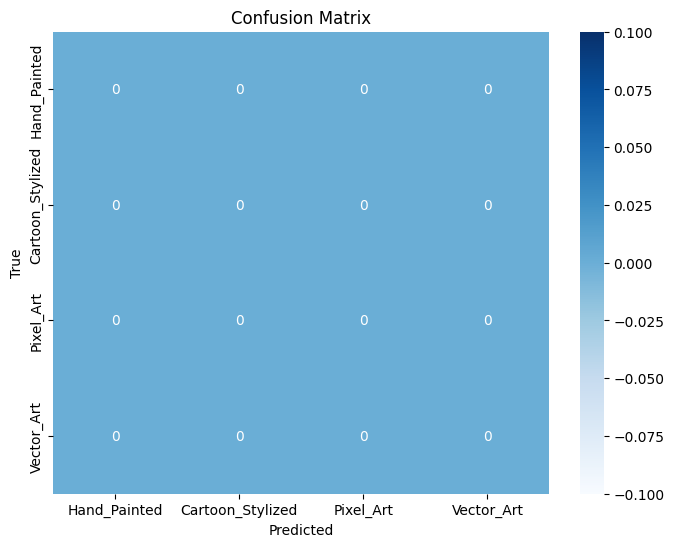

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# --- Assume y_true_filtered and y_pred_filtered are already computed ---
# Example:
# y_true_filtered = [...]
# y_pred_filtered = [...]
class_names = ["Hand_Painted", "Cartoon_Stylized", "Pixel_Art", "Vector_Art"]

# Compute confusion matrix
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=list(range(len(class_names))))

# Create a figure
plt.figure(figsize=(8, 6))

# Plot using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Save to file
save_path = '/content/runs/classify/val/confusion_matrix.png'
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print(f"✅ Confusion matrix saved to {save_path}")

In [13]:
results = model.predict(source="/content/asset_styles_yolo/test", imgsz=224)
for r in results:
    class_idx = int(r.probs.top1)
    class_name = r.names[class_idx]
    confidence = float(r.probs[class_idx])
    style, asset_type = class_name.split("_")
    print(f"{r.path} → Style: {style}, Asset: {asset_type}, Confidence: {confidence:.2f}")


FileNotFoundError: No images or videos found in /content/asset_styles_yolo/test. Supported formats are:
images: {'bmp', 'jpeg', 'heic', 'tiff', 'jpg', 'pfm', 'mpo', 'webp', 'png', 'dng', 'tif'}
videos: {'mov', 'm4v', 'webm', 'wmv', 'mpg', 'asf', 'mp4', 'avi', 'mkv', 'ts', 'mpeg', 'gif'}

In [12]:
import pandas as pd

# Assuming you have already computed:
# metrics.top1, metrics.top5, and filtered precision, recall, f1
metrics_dict = {
    "Top-1 Accuracy": metrics.top1,
    "Top-5 Accuracy": metrics.top5,
    "Precision": precision,  # from your filtered evaluation
    "Recall": recall,        # from your filtered evaluation
    "F1 Score": f1           # from your filtered evaluation
}

# Save to CSV
save_path = "/content/classification_metrics.csv"
pd.DataFrame([metrics_dict]).to_csv(save_path, index=False)
print(f"✅ Metrics saved to {save_path}")

NameError: name 'metrics' is not defined

In [ ]:
from ultralytics import YOLO
from PIL import Image

# Load your trained model (use the best weights)
model = YOLO("/content/runs/classify/train/weights/best.pt")

# Path to your test image
test_image = "/content/Styles_unzipped/Pixel Art/Background/pixel_bg_05.png"  # change this to any image path

# Run prediction
results = model.predict(source=test_image, show=True)

# Print predicted class
print("Predicted class:", results[0].names[results[0].probs.top1])
print("Confidence:", results[0].probs.top1conf)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/Styles_unzipped/Pixel Art/Background/pixel_bg_05.png: 224x224 IAT_360_CV_Project_Data 1.00, 5.6ms
Speed: 3.2ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
Predicted class: IAT_360_CV_Project_Data
Confidence: tensor(1., device='cuda:0')


In [ ]:
from ultralytics import YOLO
from pathlib import Path

# Load trained model
model = YOLO("/content/runs/classify/train/weights/best.pt")

# Path to test image
test_image = "/content/Styles_unzipped/Pixel Art/Background/pixel_bg_05.png"

# Run prediction
results = model.predict(source=test_image, verbose=False)

# Get top-1 predicted index and confidence
top1_idx = results[0].probs.top1
top1_conf = results[0].probs.top1conf

# Map index to class name
# Filter out the 5th class if it exists
class_names = ["Hand_Painted", "Cartoon_Stylized", "Pixel_Art", "Vector_Art"]
if top1_idx >= len(class_names):
    predicted_class = "Unknown / Extra Class"
else:
    predicted_class = class_names[top1_idx]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {top1_conf:.4f}")

Predicted class: Hand_Painted
Confidence: 1.0000
